In this notebook, we use PPO RL agent to learn crop-management policy on a farm constructed with farm-gym.

Remark that due to the sotchastic nature of the environment, there are seed for which the agent do not learn correctly.

## Installations

In [ ]:
!git clone https://github.com/farm-gym/farm-gym-games
%cd farm-gym-games
!pip install -e .
!pip install rlberry
!pip install -U gym

Cloning into 'farm-gym-games'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 113 (delta 53), reused 82 (delta 26), pack-reused 0
Receiving objects: 100% (113/113), 62.48 KiB | 864.00 KiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/farm-gym-games
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/farm-gym-games
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/farm-gym/farm-gym to /tmp/pip-install-2ck9gnwr/farmgym_0abee2233f5a405c8284c3f55136fb45
  Running command git clone --filter=blob:none --quiet https://github.com/farm-gym/farm-gym /tmp/pip-install-2ck9gnwr/farmgym_0abee2233f5a405c8284c3f55136fb45
  Resolved https://github.com/farm-gym/farm-gym to commit ff918cc5ae267ff82b3454373dea6076602529c9
  Installing build dependencies ... done
  Getting requirements to build wheel 

### Imports:

In [ ]:
from rlberry.agents.torch import PPOAgent
from rlberry.manager import AgentManager, evaluate_agents, plot_writer_data
from rlberry.envs import gym_make
from rlberry.agents.torch.utils.training import model_factory_from_env


import farmgym_games
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Settings :
We'll use the `Farm1` environment

In [ ]:
env_ctor, env_kwargs = gym_make, {"id": "OldV21Farm1-v0"}

We use an architecture of $256\times 256$ for both the value and policy neural 
network of ppo.

In [ ]:

policy_configs = {
    "type": "MultiLayerPerceptron",  # A network architecture
    "layer_sizes": (256, 256),  # Network dimensions
    "reshape": False,
    "is_policy": True,
}

value_configs = {
    "type": "MultiLayerPerceptron",
    "layer_sizes": (256, 256),
    "reshape": False,
    "out_size": 1,
}

### Agent code:
We use rlberry's [PPOAgent](https://rlberry.readthedocs.io/en/latest/generated/rlberry.agents.torch.PPOAgent.html#rlberry.agents.torch.PPOAgent). 
Remark that 365 days is the maximum lenght of an episode. This helps us to fix some of the parameters.

In [ ]:
manager = AgentManager(
        PPOAgent,
        (env_ctor, env_kwargs),
        agent_name="PPOAgent",
        init_kwargs=dict(
            policy_net_fn=model_factory_from_env,
            policy_net_kwargs=policy_configs,
            value_net_fn=model_factory_from_env,
            value_net_kwargs=value_configs,
            learning_rate=1e-5,
            n_steps=5 * 250,
            batch_size=250,
            eps_clip=0.2,
        ),
        fit_budget=4e5,
        eval_kwargs=dict(eval_horizon=365),
        n_fit=1,
        output_dir="ppo1_results", # results/trained agents are kept in this directory
        seed = 1
    )
manager.fit()

[INFO] 18:15: Running AgentManager fit() for PPOAgent with n_fit = 1 and max_workers = None. 
INFO:rlberry_logger:Running AgentManager fit() for PPOAgent with n_fit = 1 and max_workers = None.
/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:19

### Training reward curve

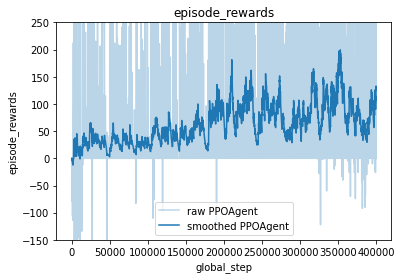

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim(-150,250)
data = plot_writer_data(manager, tag="episode_rewards", smooth_weight=0.95, ax = ax) # smoothing tensorboard-style
fig.savefig("ppo_rewards.pdf")

### Evaluation of the trained agent

In [ ]:
evaluation = evaluate_agents([manager], n_simulations=128, plot=False)
evaluation.describe()

[INFO] 18:36: Evaluating PPOAgent... 
INFO:rlberry_logger:Evaluating PPOAgent...
[INFO] Evaluation:INFO:rlberry_logger:[INFO] Evaluation:
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/usr/local/l

,PPOAgent
count,128.000000
mean,94.407758
std,55.496212
min,-11.250372
25%,54.927229
50%,85.600174
75%,126.018263
max,307.420823


Remark : only one seed was used, more seeds should be used to have a more accurate evaluation. Specify n_fits > 1 for this in the AgentManager above.

### Small peek into the agents policy

In [ ]:
agent = manager.agent_handlers[0] # select the agent from the manager

In [ ]:
env = env_ctor(**env_kwargs)
obs = env.reset()

actions_txt = ["doing nothing", 
           "1L of water", 
           "5L of water", 
           "harvesting",
           "sow some seeds",
           "scatter fertilizer",
           "scatter herbicide",
           "scatter pesticide",
           "remove weeds by hand",]
episode = pd.DataFrame()

for _ in range(100):
  is_done = False
  while not is_done :
      action = agent.policy(obs)    
      obs,reward, is_done,_ =  env.step(action)
      episode = pd.concat([episode, pd.DataFrame({'action':[actions_txt[action]],
                                                  'reward':[reward]})], ignore_index=True)
  env.reset()


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. 

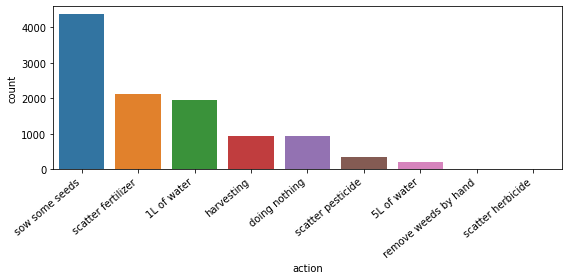

In [ ]:

fig, ax = plt.subplots(figsize=(8,4))
sns.countplot(data = episode, x = "action", order = episode['action'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
fig.savefig('ppo_actions.pdf')

This agent did not learn how to put pesticide and herbicide, it learned that pesticide and herbicide can bring negative reward. On the other hand, it learned that fertilizer was important to have healthy plants.

Remark that sowing seeds does nothing after the first time (once the plant is already there) and similarly, harvesting does nothing if the plant do not bear fruits yet. Hence, the agent learned that doing nothing is not a bad policy most of the time.